# Pretraining

For this stage, we would implement:

1. Training loop
2. Model eval
3. Load pretrained weights

Before starting, let's recap on text generation, text evaluation, and training val & losses.

In [7]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # prevent div by 0 during normalization
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # use biased variance, so div by n, not n-1
        # this is practically negligible for large n, but matches the original GPT-2 implementation
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,
                context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # reduces the projection dim to match desired output dim
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # uses linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # split matrix adding num_heads dim
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) # Then we unroll the last dim: d_out -> num_heads, head_dim
        values = values.view(b, num_tokens, self.num_heads, self.head_dim) # output (b, num_tokens, num_heads, head_dim)

        keys = keys.transpose(1, 2) # transpose from b, num_tokens, num_heads, head_dim -->
        queries = queries.transpose(1, 2) # b, num_heads, num_tokens, head_dim
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2) # transpose back to b, num_tokens, num_heads, head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # reshape to b, num_tokens, d_out
        context_vec = self.out_proj(context_vec) # adds optional linear projection
        return context_vec

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"] * 4),
            GELU(),
            nn.Linear(cfg["emb_dim"] * 4, cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut= nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x # shortcut connection for attn block
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # add the original input to the output of the attn block

        shortcut = x # shortcut connection for ff block
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # add the original input to the output of the ff layer
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device) # select device to train
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [8]:
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256, # shorten from 1024 to 256 for faster training
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
"qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [9]:
# implemeting the text generation

import tiktoken

def generate_text_simple(model, idx, max_new_tokens, context_size): # idx is a (batch, n_tokens) tensor
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # crops current context if it exceeds context size
        with torch.no_grad():
            logits = model(idx_cond) # model generates logits for the next token

        logits = logits[:, -1, :] # selects the last token in the sequence: (batch, n_tokens, vocab_size) 
                                    #-> (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1) # converts logits to probabilities
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # selects the most likely token (batch, 1)
        idx = torch.cat([idx, idx_next], dim=-1) # appends the new token to the sequence, where idx has shape (batch, n_tokens+1)
    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dim
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dim
    return tokenizer.decode(flat.tolist())

In [10]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [11]:
# calculate text generation loss. let's see first an example on how to calculate the loss for a single batch

inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]]) # "I really like"]

targets = torch.tensor([[3626, 6100, 345], # ["effort moves you",
                        [1107, 588, 11311]]) # "really like

with torch.no_grad():
    logits = model(inputs)
    probas = torch.softmax(logits, dim=-1)
print(probas.shape)

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("\nToken IDs:\n", token_ids)

print(f"\nTargets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

torch.Size([2, 3, 50257])

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [12]:
# printing the probabilities of the target tokens
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [14]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print("\nLog probabilities:\n", log_probas)

#avg_log_proba = log_probas.mean()
avg_log_probas = torch.mean(log_probas)
print("\nAvg log probability:", avg_log_probas)

neg_avg_log_probas = avg_log_probas * -1
print("\nAvg neg log prob:", neg_avg_log_probas) # also known as cross-entropy loss


Log probabilities:
 tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])

Avg log probability: tensor(-10.7940)

Avg neg log prob: tensor(10.7940)


**Cross entropy loss** At its core, the cross entropy loss is a popular measure in machine learning and deep
learning that measures the difference between two probability distributions -- typically, the true distribution of labels (here, tokens in a dataset) and the predicted distribution from a model (for instance, the token probabilities generated by an LLM). 

cross entropy ≈= negative avg log probab

In [15]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [16]:
# cross entropy will calculate the log softmax and then the negative log likelihood
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("\nCross entropy loss:", loss)


Cross entropy loss: tensor(10.7940)



**Perplexity** is a measure often used alongside cross entropy loss to evaluate the performance of models in tasks like language modeling. It can provide a more interpretable way to understand the uncertainty of a model in predicting the next token in a
sequence.

Perplexity measures how well the probability distribution predicted by the model
matches the actual distribution of the words in the dataset. Similar to the loss, a lower
perplexity indicates that the model predictions are closer to the actual distribution.

perplexity = torch.exp(loss)

In [17]:
perplexity = torch.exp(loss)
print("Perplexity:", perplexity)

Perplexity: tensor(48725.8203)


Perplexity is often considered more interpretable than the raw loss value because it signifies the effective vocabulary size about which the model is uncertain at each step. In the given example, this would translate to the model being unsure about which among 48,725 tokens in the vocabulary to generate as the next token.

While cross-entropy represents the average negative log probability of correct predictions, perplexity translates this into the effective number of choices the model is uncertain about at each step. If a model assigns equal probability to all tokens in a vocabulary of size 𝑉, its perplexity is 𝑉, meaning it is as uncertain as random guessing. Lower perplexity indicates greater confidence, while higher perplexity suggests the model is struggling to distinguish between many possible outputs.

Now let's evaluate the training and validations losses

In [18]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
    print(text_data[:100])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [19]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [20]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) # tokenizes the entire text
        
        for i in range(0, len(token_ids) - max_length, stride):
            # use sliding window to chunk the book into overlapping sequences of max_length
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids) # returns total rows in the dataset
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx] # return single row
        
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    
    tokenizer = tiktoken.get_encoding("gpt2") # initialize the tokenizer

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) # create the dataset

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, # create the dataloader
                            drop_last=drop_last, num_workers=num_workers)
    
    return dataloader

In [22]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2, # ridiculously small batch size for demonstration purposes
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [23]:
train_loader

In [24]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [25]:
# implement a function to calculate loss entropy for a given batch

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )
    return loss

In [26]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) # iterate over all batches if num_batches is not specified
    else:
        num_batches = min(num_batches, len(data_loader)) # reduces the number of batches if num batches exceeds the total number of batches
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item() # sum loss for each batch
        else:
            break
    return total_loss / num_batches # return the average loss

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model.to(device)
with torch.no_grad(): # disable gradient tracking for efficiency since we're not training
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Device: cpu
Training loss: 10.987583690219456
Validation loss: 10.98110580444336


## 2) Training

1) Iterate over training epochs
2) Iterate over batches in each training epochs
3) Reset loss gradients from previous batch iteration
4) Calculate loss on current batch
5) Backward pass to calculate loss gradient
6) Update model weights using loss gradients
7) Print training and validation set losses
8) Generate sample text for visual inspection

In [28]:
# main function for pretraining LLM
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], [] # initialize lists to store losses and tokens seen
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs): # starts main training loop
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # reset loss gradients to zero from the previous iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # backpropagate to compute gradients
            optimizer.step() # update model parameters
            tokens_seen += input_batch.numel() # count the number of tokens seen
            global_step += 1

            if global_step % eval_freq == 0: # evaluate the model on the validation set. Optional step
                train_loss, val_loss = evaluate_model( # not defined yet
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample( # not define yet
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # dropouts are disabled during evaluation for reproducibility
    with torch.no_grad(): # disable gradient tracking for efficiency since we're not training
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

# evaluate_model gives a numeric loss  while generate_and_print_sample gives 
# a sample text for better understanding of the model's performance

In [30]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1) # AdamW optimizer
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

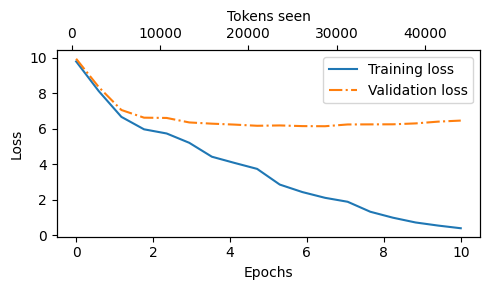

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

A clear sign of overfitting to see the validation loss diverge early from the training loss.

In [39]:
# Text generation strategies

model.to("cpu") # move model to CPU for faster generation
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [40]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model, 
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 100,
    context_size = GPT_CONFIG_124M["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gisburn, he knew just what the surest way of the plain oak panelling of the room.

"Oh, a balancing, I had it over the mantel-piece, and he wouldn't let it stay."

Yes--


Since the model will always generate the same outputs even if we run the same input text, we would add the temperature parameter, which is a technique that adds a probabilist selection process to the next-token generation task -- replacing the previous greedy decoding from argmax -> function that samples from a probab distribution

In [42]:
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [44]:
# a sample output logist from "Every effort moves you"
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [45]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [50]:
# but if we test it 1000 times:

def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
            for i in range(1000)]  # sample 1000 tokens
    sample_ids = torch.bincount(torch.tensor(sample))
    for i, count in enumerate(sample_ids):
        print(f"{inverse_vocab[i]}: {count.item()}")

print_sampled_tokens(probas)

closer: 73
every: 0
effort: 0
forward: 582
inches: 2
moves: 0
pizza: 0
toward: 343


In [68]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

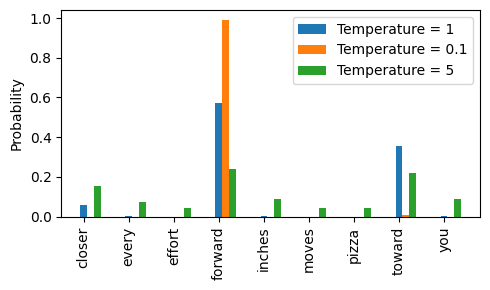

In [53]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
        for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
    bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [67]:
import numpy as np

def softmax(logits, temperature=1.0):
    # Scale the logits by dividing by the temperature
    scaled_logits = logits / temperature
    # Subtract the maximum value for numerical stability
    exp_logits = np.exp(scaled_logits)
    return exp_logits, exp_logits / np.sum(exp_logits)

# Example logits
logits = np.array([1, 2, 3, 4, 5])

# Define different temperature values
temperatures = [0.5, 1.0, 2.0]

for T in temperatures:
    exp_logits, probabilities = softmax(logits, temperature=T)
    print(exp_logits)
    print(f"Temperature = {T}: {probabilities}")

[7.38905610e+00 5.45981500e+01 4.03428793e+02 2.98095799e+03
 2.20264658e+04]
Temperature = 0.5: [2.90075868e-04 2.14338686e-03 1.58376057e-02 1.17024957e-01
 8.64703974e-01]
[  2.71828183   7.3890561   20.08553692  54.59815003 148.4131591 ]
Temperature = 1.0: [0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]
[ 1.64872127  2.71828183  4.48168907  7.3890561  12.18249396]
Temperature = 2.0: [0.05801222 0.09564598 0.15769356 0.25999272 0.42865553]


In [75]:
# List of temperatures to test
temperatures = [1, 0.1, 5]

# Define a function to sample 1000 tokens and print their frequencies
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(1000)]
    sample_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, count in enumerate(sample_ids):
        print(f"{inverse_vocab[i]}: {count.item()}")

# List of temperature values to test
temperatures = [1, 0.1, 5]

# Apply the softmax_with_temperature function and sample tokens for each temperature
for T in temperatures:
    print(f"Temperature: {T}")
    probas = softmax_with_temperature(next_token_logits, T)
    print_sampled_tokens(probas)
    print("-" * 40)

Temperature: 1
closer: 73
every: 0
effort: 0
forward: 582
inches: 2
moves: 0
pizza: 0
toward: 343
you: 0
----------------------------------------
Temperature: 0.1
closer: 0
every: 0
effort: 0
forward: 985
inches: 0
moves: 0
pizza: 0
toward: 15
you: 0
----------------------------------------
Temperature: 5
closer: 165
every: 75
effort: 42
forward: 239
inches: 71
moves: 46
pizza: 32
toward: 227
you: 103
----------------------------------------
